In [34]:
#Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pathlib
import cv2
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, RMSprop, Adamax
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.get_logger().setLevel('ERROR')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create parameters needed to read in the data
batch_size = 32
img_height = 160
img_width = 160
IMG_SIZE = (160, 160)

In [3]:
# Specify the directory where the data is located
data_dir = './Intel_image/'

In [4]:
# Create a TF Dataset object as follows - one for training and one for validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 13628 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 3406 files for validation.


In [6]:
# Split the validation set into and hold out 5 batches as test data
test_dataset = val_ds.take(5)
val_ds = val_ds.skip(5)

In [7]:
# Check class names
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(32, 160, 160, 3)
(32,)


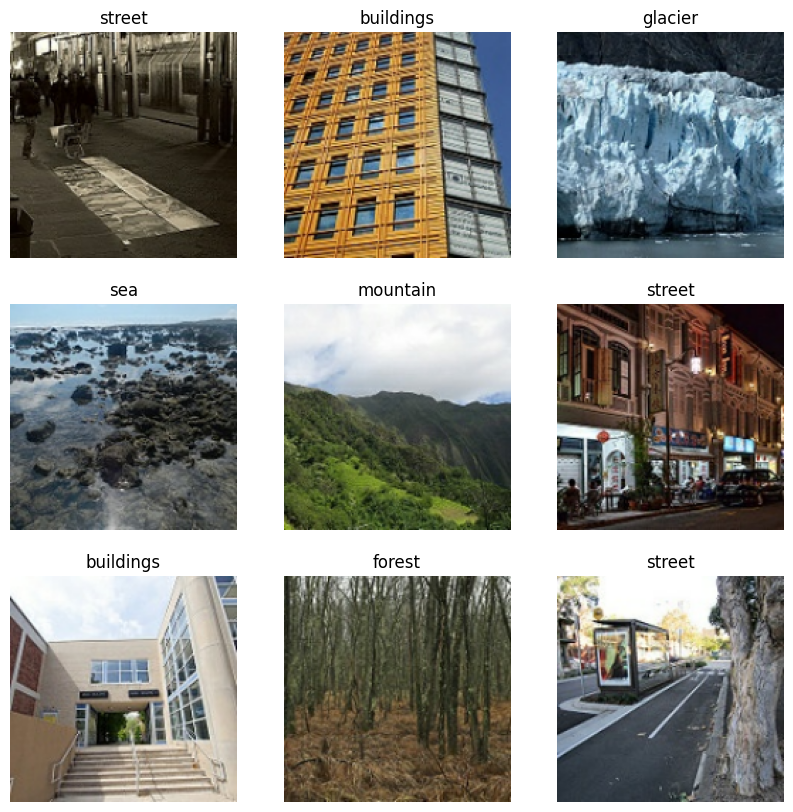

In [8]:
# Build images from matrices and print off the samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [9]:
# Define the CNN, feed in the train ds and rescale to range of 0-1 and use 3 convolution layers and 3 max pooling layers

CNN_model = Sequential()
CNN_model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height,img_width,3),activation = 'relu',padding = 'same'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Flatten())
CNN_model.add(Dense(128,activation = 'relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(6,activation = 'softmax'))


CNN_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [10]:
# Train the model using 15 epochs
epochs=15
history = CNN_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/15
426/426 [==============================] - 42s 77ms/step - loss: 2.0862 - accuracy: 0.3206 - val_loss: 1.2630 - val_accuracy: 0.5034
Epoch 2/15
426/426 [==============================] - 27s 63ms/step - loss: 1.3186 - accuracy: 0.4479 - val_loss: 1.0575 - val_accuracy: 0.5940
Epoch 3/15
426/426 [==============================] - 25s 57ms/step - loss: 1.2039 - accuracy: 0.5071 - val_loss: 0.9587 - val_accuracy: 0.6352
Epoch 4/15
426/426 [==============================] - 26s 60ms/step - loss: 1.1177 - accuracy: 0.5517 - val_loss: 0.9181 - val_accuracy: 0.6513
Epoch 5/15
426/426 [==============================] - 30s 68ms/step - loss: 1.0590 - accuracy: 0.5861 - val_loss: 0.8640 - val_accuracy: 0.6888
Epoch 6/15
426/426 [==============================] - 29s 66ms/step - loss: 1.0014 - accuracy: 0.6063 - val_loss: 0.8251 - val_accuracy: 0.6953
Epoch 7/15
426/426 [==============================] - 28s 64ms/step - loss: 0.9468 - accuracy: 0.6321 - val_loss: 0.7648 - val_accuracy:

In [11]:
# Use test data to test the model
test_loss, test_acc = CNN_model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 1s - loss: 0.7587 - accuracy: 0.7812 - 841ms/epoch - 168ms/step

Test accuracy: 0.78125


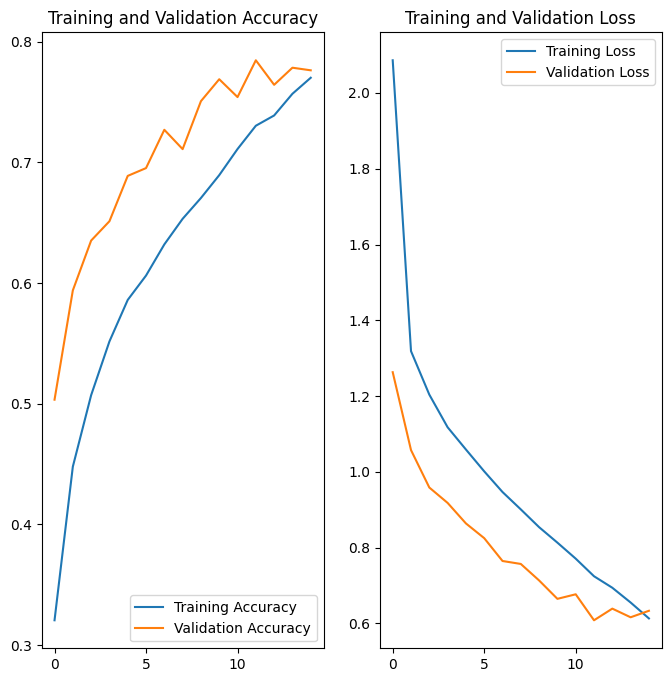

In [12]:
# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
test_prediction = CNN_model.predict(test_dataset) 
predicted_labels = np.argmax(test_prediction, axis=1)

5/5 [==============================] - 1s 51ms/step


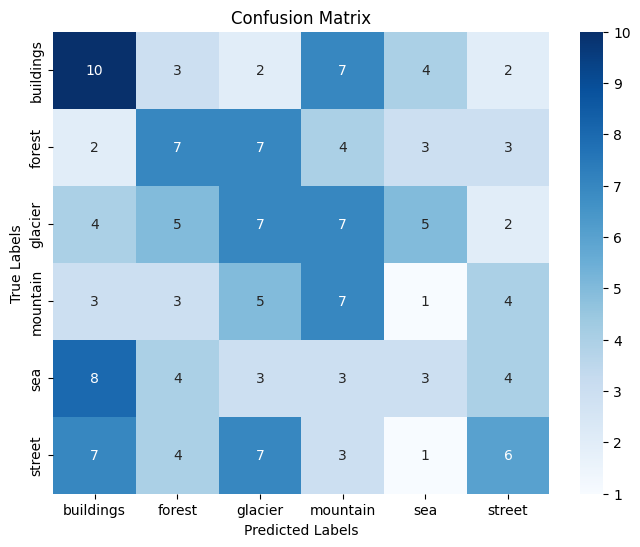

In [14]:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
confusion_mat = confusion_matrix(true_labels, predicted_labels)
# Define class names if not already defined
class_names = train_ds.class_names

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

-----

### Defining the CNN

In [15]:
# Define the CNN, feed in the train ds and rescale to range of 0-1 and use 3 convolution layers and 3 max pooling layers

CNN_model2 = Sequential()
CNN_model2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(img_height,img_width,3),activation = 'relu',padding = 'same'))
CNN_model2.add(MaxPooling2D(pool_size=(2,2)))
CNN_model2.add(Conv2D(filters=64,kernel_size=(3,3),activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2,2)))
CNN_model2.add(Conv2D(filters=128,kernel_size=(3,3),activation = 'relu'))
CNN_model2.add(MaxPooling2D(pool_size=(2,2)))
#CNN_model2.add(BatchNormalization())
CNN_model2.add(Flatten())
CNN_model2.add(Dense(128,activation = 'relu'))
CNN_model2.add(Dropout(0.5))
CNN_model2.add(Dense(6,activation = 'softmax'))


CNN_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

CNN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 128)     

In [16]:
# Train the model using 15 epochs
epochs=15
history = CNN_model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/15
426/426 [==============================] - 45s 104ms/step - loss: 2.5177 - accuracy: 0.1967 - val_loss: 1.7801 - val_accuracy: 0.1836
Epoch 2/15
426/426 [==============================] - 46s 106ms/step - loss: 1.7848 - accuracy: 0.1825 - val_loss: 1.7879 - val_accuracy: 0.1774
Epoch 3/15
426/426 [==============================] - 40s 93ms/step - loss: 1.7870 - accuracy: 0.1865 - val_loss: 1.7755 - val_accuracy: 0.2126
Epoch 4/15
426/426 [==============================] - 48s 113ms/step - loss: 1.7615 - accuracy: 0.2058 - val_loss: 1.7197 - val_accuracy: 0.2375
Epoch 5/15
426/426 [==============================] - 46s 106ms/step - loss: 1.7066 - accuracy: 0.2520 - val_loss: 1.6174 - val_accuracy: 0.2905
Epoch 6/15
426/426 [==============================] - 44s 102ms/step - loss: 1.6246 - accuracy: 0.3150 - val_loss: 1.3795 - val_accuracy: 0.4421
Epoch 7/15
426/426 [==============================] - 45s 105ms/step - loss: 1.3246 - accuracy: 0.4648 - val_loss: 0.9474 - val_acc

In [17]:
# Use test data to test the model
test_loss, test_acc = CNN_model2.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 1s - loss: 0.8770 - accuracy: 0.7812 - 922ms/epoch - 184ms/step

Test accuracy: 0.78125


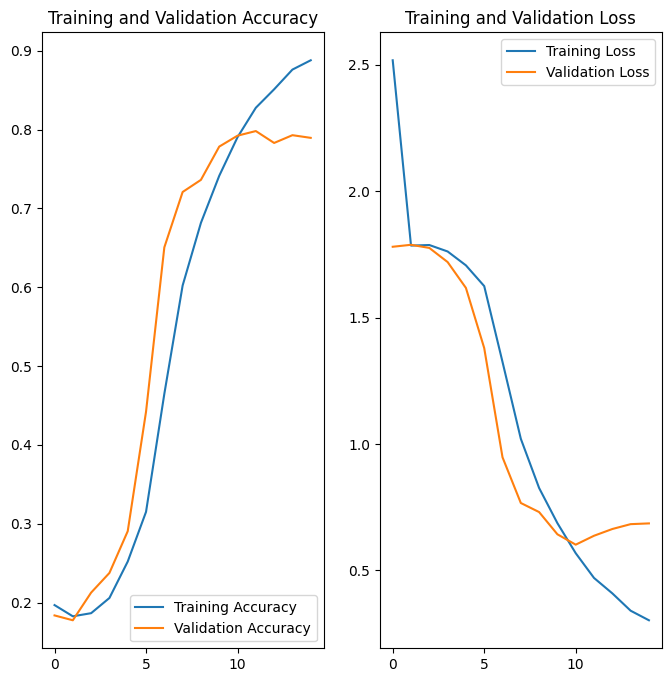

In [18]:
# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_prediction = CNN_model2.predict(test_dataset) 
predicted_labels = np.argmax(test_prediction, axis=1)

5/5 [==============================] - 0s 38ms/step


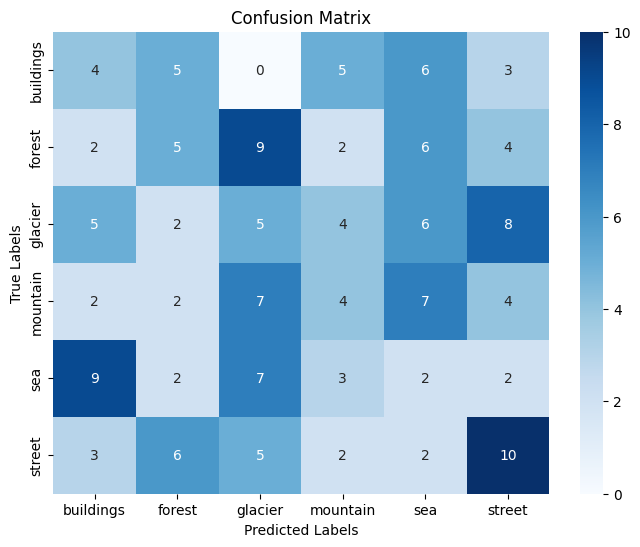

In [20]:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
confusion_mat1 = confusion_matrix(true_labels, predicted_labels)
class_names = train_ds.class_names  

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat1, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

(32, 160, 160, 3)
(32,)


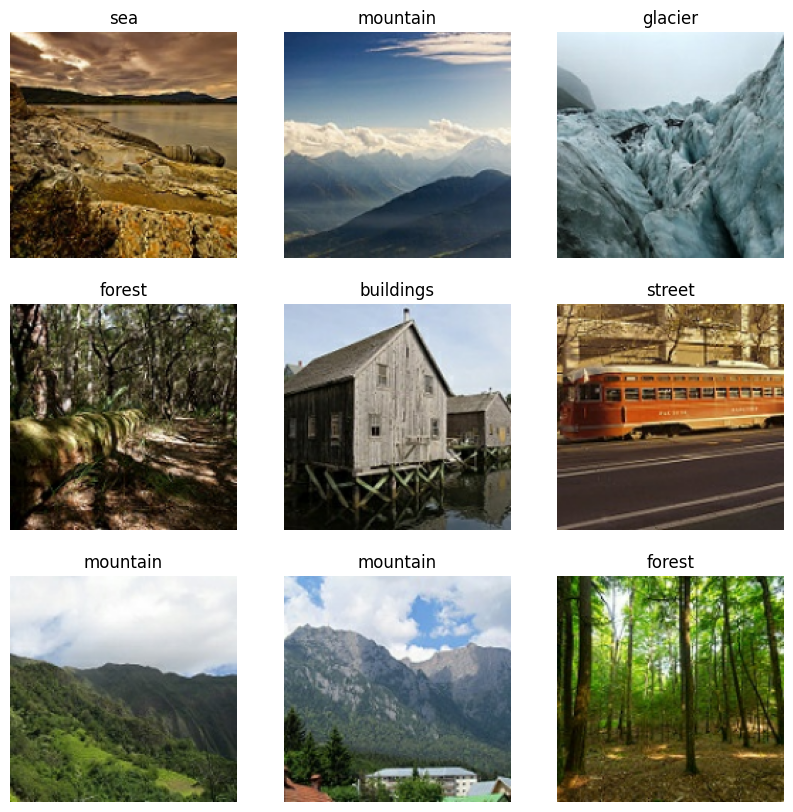

In [21]:
# Build images from matrices and print off the samples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

## data_augmentation

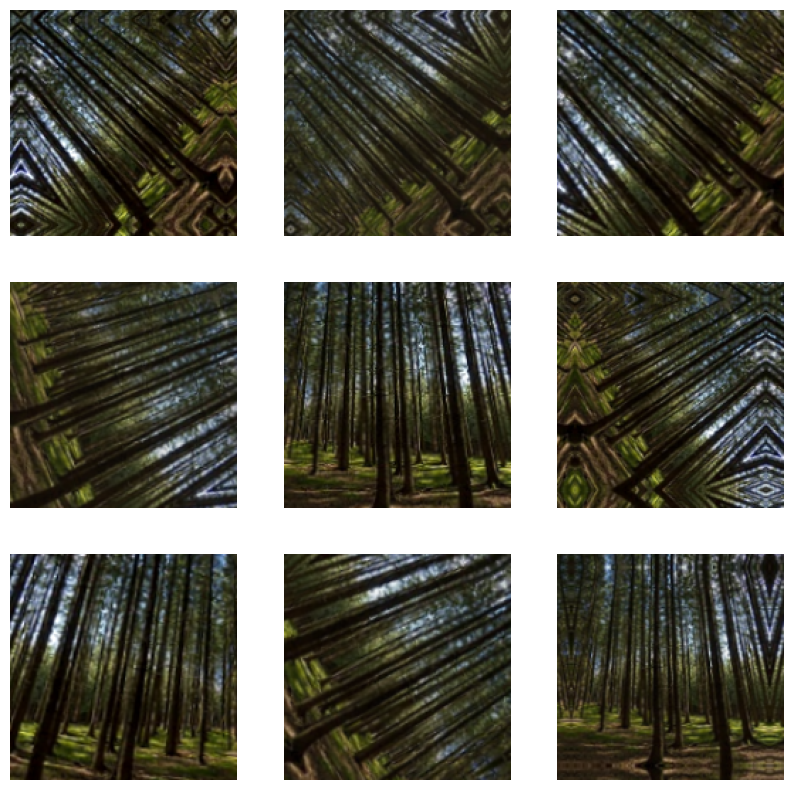

In [22]:
# Define your data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

# Apply data augmentation to the dataset
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### MobileNetV2 pre-trained model

In [56]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
mobilenet= MobileNetV2(input_shape = (160,160,3), weights = 'imagenet', include_top = False)

for layer in mobilenet.layers:
    layer.trainable = False
    
x = layers.Flatten()(mobilenet.output)
x = layers.Dense(1024, activation = 'relu')(x) 
x = layers.Dense(6, activation='softmax')(x)

mobile_model = Model(inputs = mobilenet.input, outputs = x)

In [57]:
# Optimize the data using 'Adam' 
mobile_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [58]:
mobile_history = mobile_model.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, epochs=15)

Epoch 1/15
10/10 [==============================] - 8s 608ms/step - loss: 3.7111 - accuracy: 0.4281 - val_loss: 1.8854 - val_accuracy: 0.5616
Epoch 2/15
10/10 [==============================] - 4s 479ms/step - loss: 1.2431 - accuracy: 0.6656 - val_loss: 1.2843 - val_accuracy: 0.6722
Epoch 3/15
10/10 [==============================] - 5s 522ms/step - loss: 1.2007 - accuracy: 0.6438 - val_loss: 1.1301 - val_accuracy: 0.6664
Epoch 4/15
10/10 [==============================] - 5s 548ms/step - loss: 1.2115 - accuracy: 0.6562 - val_loss: 1.0925 - val_accuracy: 0.6707
Epoch 5/15
10/10 [==============================] - 5s 525ms/step - loss: 0.9933 - accuracy: 0.6594 - val_loss: 0.8450 - val_accuracy: 0.6999
Epoch 6/15
10/10 [==============================] - 4s 456ms/step - loss: 0.7635 - accuracy: 0.7094 - val_loss: 0.7721 - val_accuracy: 0.7360
Epoch 7/15
10/10 [==============================] - 5s 497ms/step - loss: 0.9576 - accuracy: 0.6656 - val_loss: 0.6376 - val_accuracy: 0.7560
Epoch 

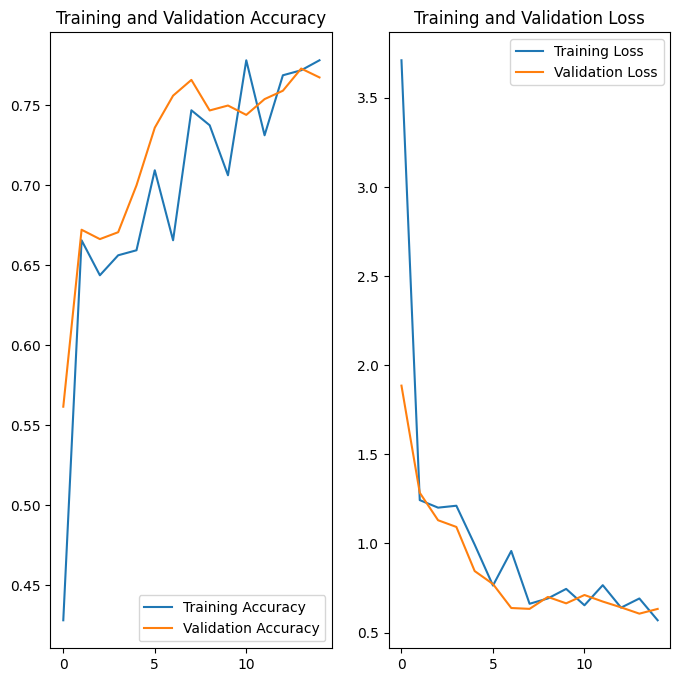

In [59]:
acc = mobile_history.history['accuracy']
val_acc = mobile_history.history['val_accuracy']
loss = mobile_history.history['loss']
val_loss = mobile_history.history['val_loss']
epochs_range = range(len(acc))

# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
# Optimize the data using 'SGD'
mobile_model2 = Model(inputs = mobilenet.input, outputs = x)

In [61]:
mobile_model2.compile(optimizer= SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [62]:
mobile_history2 = mobile_model2.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, epochs=15)

Epoch 1/15
10/10 [==============================] - 8s 610ms/step - loss: 0.3468 - accuracy: 0.8594 - val_loss: 0.5816 - val_accuracy: 0.7837
Epoch 2/15
10/10 [==============================] - 4s 440ms/step - loss: 0.3755 - accuracy: 0.8656 - val_loss: 0.5770 - val_accuracy: 0.7874
Epoch 3/15
10/10 [==============================] - 5s 521ms/step - loss: 0.3586 - accuracy: 0.8687 - val_loss: 0.5667 - val_accuracy: 0.7951
Epoch 4/15
10/10 [==============================] - 5s 508ms/step - loss: 0.3432 - accuracy: 0.8719 - val_loss: 0.5788 - val_accuracy: 0.7884
Epoch 5/15
10/10 [==============================] - 5s 519ms/step - loss: 0.3912 - accuracy: 0.8750 - val_loss: 0.5564 - val_accuracy: 0.7939
Epoch 6/15
10/10 [==============================] - 5s 541ms/step - loss: 0.3272 - accuracy: 0.8719 - val_loss: 0.5678 - val_accuracy: 0.7933
Epoch 7/15
10/10 [==============================] - 5s 507ms/step - loss: 0.3779 - accuracy: 0.8719 - val_loss: 0.5753 - val_accuracy: 0.7951
Epoch 

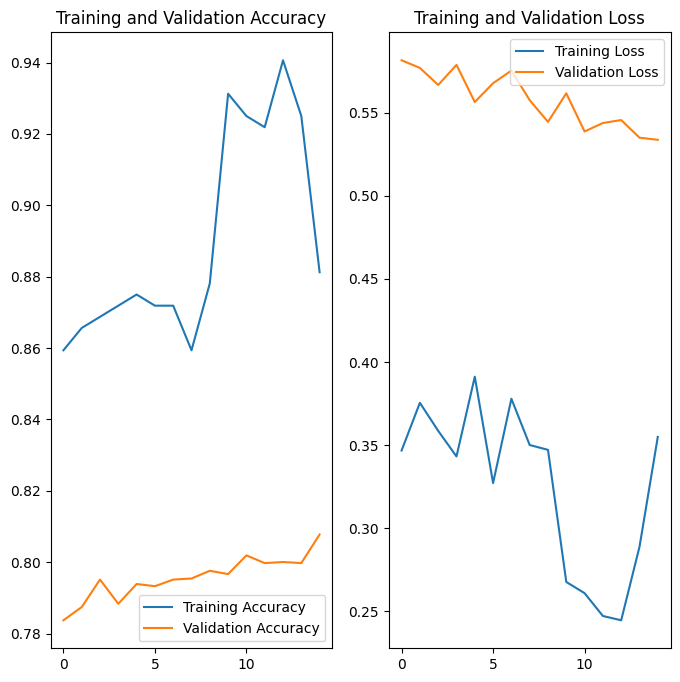

In [63]:
acc = mobile_history2.history['accuracy']
val_acc = mobile_history2.history['val_accuracy']
loss = mobile_history2.history['loss']
val_loss = mobile_history2.history['val_loss']
epochs_range = range(len(acc))

# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

----

### VGG16 pre-trained model

In [64]:
vgg = VGG16(input_shape = (160,160,3), weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False
    
x = layers.Flatten()(vgg.output)
x = layers.Dense(1024, activation = 'relu')(x) 
x = layers.Dense(6, activation='softmax')(x)

vgg_model = Model(inputs = vgg.input, outputs = x)

In [65]:
# Optimize the data using 'Adam'
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [66]:
vgg_history = vgg_model.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, epochs=15)

Epoch 1/15
10/10 [==============================] - 26s 2s/step - loss: 5.9362 - accuracy: 0.5437 - val_loss: 2.5820 - val_accuracy: 0.7927
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 3.0954 - accuracy: 0.7969 - val_loss: 2.7942 - val_accuracy: 0.8216
Epoch 3/15
10/10 [==============================] - 16s 2s/step - loss: 4.0319 - accuracy: 0.7719 - val_loss: 2.5036 - val_accuracy: 0.8580
Epoch 4/15
10/10 [==============================] - 15s 2s/step - loss: 2.3569 - accuracy: 0.8594 - val_loss: 2.4187 - val_accuracy: 0.8512
Epoch 5/15
10/10 [==============================] - 15s 2s/step - loss: 3.1494 - accuracy: 0.8125 - val_loss: 2.2484 - val_accuracy: 0.8608
Epoch 6/15
10/10 [==============================] - 15s 2s/step - loss: 1.7784 - accuracy: 0.8875 - val_loss: 2.2244 - val_accuracy: 0.8626
Epoch 7/15
10/10 [==============================] - 14s 2s/step - loss: 2.5862 - accuracy: 0.8531 - val_loss: 2.3720 - val_accuracy: 0.8540
Epoch 8/15
10/10 [==

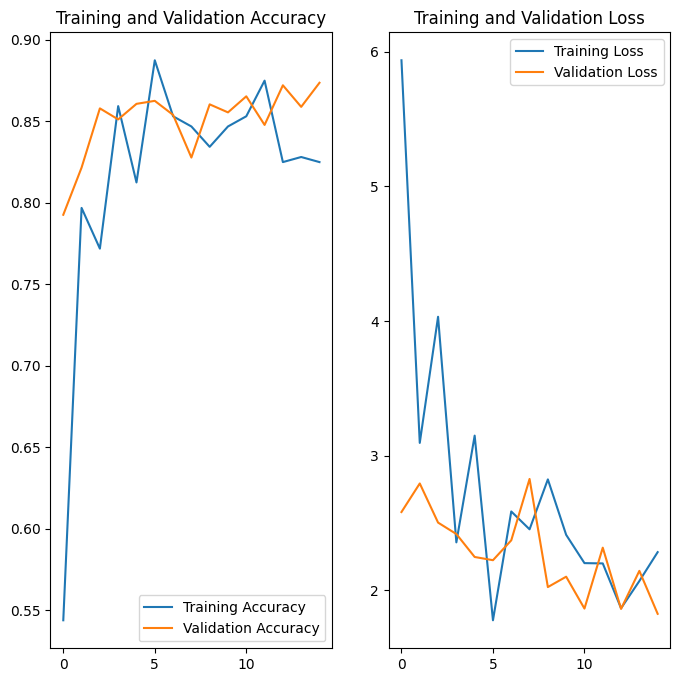

In [68]:
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']
epochs_range = range(len(acc))

# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
# Optimize the data using 'SGD'
vgg_model2 = Model(inputs = vgg.input, outputs = x)

In [71]:
vgg_model2.compile(optimizer= SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics='accuracy')

In [72]:
vgg_history2 = vgg_model2.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, epochs=15)

Epoch 1/15
10/10 [==============================] - 14s 1s/step - loss: 0.3617 - accuracy: 0.9625 - val_loss: 1.7825 - val_accuracy: 0.8765
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 0.3687 - accuracy: 0.9656 - val_loss: 1.8094 - val_accuracy: 0.8731
Epoch 3/15
10/10 [==============================] - 15s 2s/step - loss: 0.1677 - accuracy: 0.9563 - val_loss: 1.8156 - val_accuracy: 0.8777
Epoch 4/15
10/10 [==============================] - 13s 1s/step - loss: 0.1483 - accuracy: 0.9625 - val_loss: 1.9234 - val_accuracy: 0.8703
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 0.4507 - accuracy: 0.9469 - val_loss: 1.8442 - val_accuracy: 0.8728
Epoch 6/15
10/10 [==============================] - 15s 2s/step - loss: 0.3216 - accuracy: 0.9531 - val_loss: 1.6878 - val_accuracy: 0.8814
Epoch 7/15
10/10 [==============================] - 15s 2s/step - loss: 0.3762 - accuracy: 0.9563 - val_loss: 1.8567 - val_accuracy: 0.8805
Epoch 8/15
10/10 [==

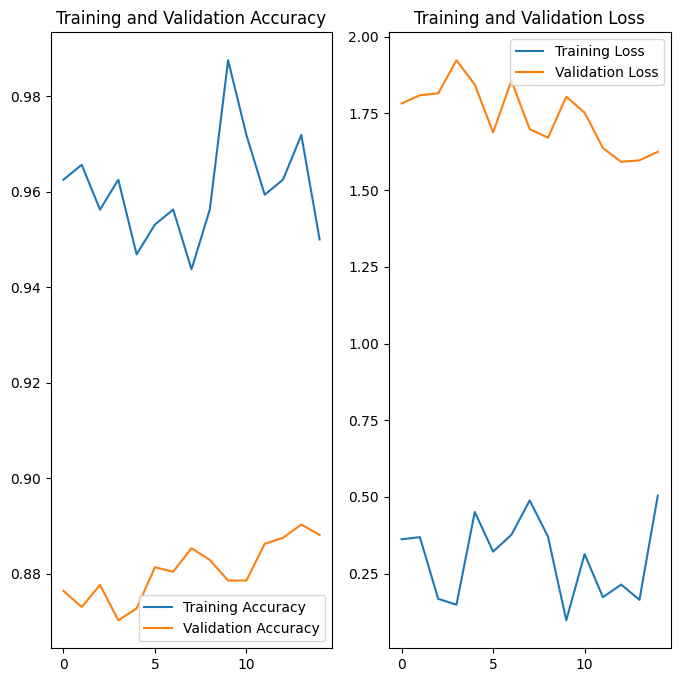

In [73]:
acc = vgg_history2.history['accuracy']
val_acc = vgg_history2.history['val_accuracy']
loss = vgg_history2.history['loss']
val_loss = vgg_history2.history['val_loss']
epochs_range = range(len(acc))

# Plot the training performance using acc, val_acc, val_loss
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

----

### Fine-Tuning
- This will be done by using the VGG16 pretrained model that has been optimized with SGD because it provided the best accuracy

In [79]:
# Check the number of trainable variables in your model
num_trainable_vars = len(vgg_model2.trainable_variables)
print("Number of trainable variables:", num_trainable_vars)

initial_epochs = 15

# Check if your validation dataset contains data
if val_ds is not None:
    # Evaluate the model on the validation dataset
    loss0, accuracy0 = vgg_model2.evaluate(val_ds)
    print("Initial loss: {:.2f}".format(loss0))
    print("Initial accuracy: {:.2f}".format(accuracy0))
else:
    print("Validation dataset is empty or not provided.")

# Train the model on your training dataset
history = vgg_model2.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Number of trainable variables: 4
102/102 [==============================] - 13s 119ms/step - loss: 0.7962 - accuracy: 0.9008
Initial loss: 0.80
Initial accuracy: 0.90
Epoch 1/15
426/426 [==============================] - 66s 155ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.7881 - val_accuracy: 0.9017
Epoch 2/15
426/426 [==============================] - 69s 160ms/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.7902 - val_accuracy: 0.9033
Epoch 3/15
426/426 [==============================] - 73s 170ms/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.8075 - val_accuracy: 0.9026
Epoch 4/15
426/426 [==============================] - 67s 157ms/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.8021 - val_accuracy: 0.8999
Epoch 5/15
426/426 [==============================] - 65s 152ms/step - loss: 0.0077 - accuracy: 0.9990 - val_loss: 0.7990 - val_accuracy: 0.9026
Epoch 6/15
426/426 [==============================] - 69s 161ms/step - loss: 0.0081 - accuracy: 0.9990 - val

In [80]:
CNN_model2.compile(optimizer=Adam(learning_rate=0.0001), 
                   loss='sparse_categorical_crossentropy', 
                   metrics = ['accuracy'])

In [82]:
# continue training adding some fine-tuning epochs to our normal training epochs
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_fine = CNN_model2.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds
                        )

Epoch 15/30
426/426 [==============================] - 31s 71ms/step - loss: 0.2781 - accuracy: 0.9004 - val_loss: 0.6636 - val_accuracy: 0.8019
Epoch 16/30
426/426 [==============================] - 33s 75ms/step - loss: 0.2346 - accuracy: 0.9162 - val_loss: 0.7022 - val_accuracy: 0.8090
Epoch 17/30
426/426 [==============================] - 31s 72ms/step - loss: 0.2024 - accuracy: 0.9272 - val_loss: 0.6933 - val_accuracy: 0.8093
Epoch 18/30
426/426 [==============================] - 33s 75ms/step - loss: 0.1726 - accuracy: 0.9388 - val_loss: 0.9270 - val_accuracy: 0.8078
Epoch 19/30
426/426 [==============================] - 33s 75ms/step - loss: 0.1529 - accuracy: 0.9450 - val_loss: 0.7664 - val_accuracy: 0.8130
Epoch 20/30
426/426 [==============================] - 32s 73ms/step - loss: 0.1500 - accuracy: 0.9475 - val_loss: 0.7693 - val_accuracy: 0.8176
Epoch 21/30
426/426 [==============================] - 31s 71ms/step - loss: 0.1320 - accuracy: 0.9524 - val_loss: 0.7973 - val_ac

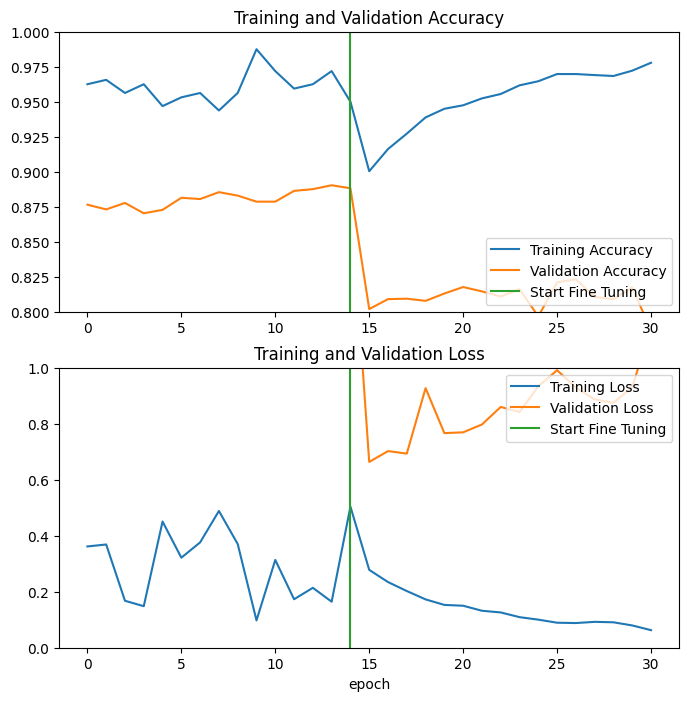

In [83]:
# Generate the plot for visualization
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

----